# CSF ANALYSIS FOR PPMI data


Created: 2018-08-07    
By: Hirotaka Iwaki

Required data for this analysis:    
"Current_Biospecimen_Analysis_Results.csv" from PPMI-LONI    
event_ID_ref_data and demographic_data derived from PPMI datasets ([codes](https://github.com/hirotaka-i/PDcohorts/blob/master/PPMI/codes))   
Genotypings data from LNG: Imputed and filtered (MAF >0.001, Rsq >0.3, and cut per 20K SNPs per file.)



## Objective/Model
GWAS analysis for CSF $\alpha$-synuclein concentrations.    
A linear model adjusting for sex, age, and CSF hemoglobin >200 with random intercept for individuals.     
After diagnosis, the CSF $\alpha$-synuclein concentrations don't change much. -> 

## CSF file
Extract $\alpha$-synuclein concentrations and CSF hemoglobin levels from "Current_Biospecimen_Analysis_Results.csv" and give the visiting date from event_ID_ref_data.

In [170]:
%%bash
mkdir -p temp
awk 'BEGIN{FS=",";OFS="\t"}/CSF Alpha-synuclein/{print $1"_"$4,$7}' data/Current_Biospecimen_Analysis_Results.csv | \
sed 's/"//g' | sort > temp/asyn.txt
awk 'BEGIN{FS=",";OFS="\t"}/CSF Hemoglobin/{print $1"_"$4,$7}' data/Current_Biospecimen_Analysis_Results.csv | \
sed 's/"//g' | sort > temp/hemo.txt
awk 'BEGIN{FS=",";OFS="\t"}//{print $1"_"$2,$3}' data/01_extract_EVENTDATE.csv | \
sed 's/"//g' | sort > temp/event_date.txt
join temp/asyn.txt temp/hemo.txt | join - temp/event_date.txt | sed 's/_/ /g' > temp/asyn_hemo.txt 

## Merge the above  file with Demographic file

In [173]:
%%bash
echo '
library(dplyr)
library(data.table)
t1 = fread("data/02_LatestDiagDemog.csv", header=T)
t2 = fread("temp/asyn_hemo.txt", header=F, , na.strings="N/A") %>% 
    mutate(V1 = as.character(V1)) %>% #  V1(ID) regarded as int
    filter(!is.na(V2) & !is.na(V3)) # delete "N/A" value observation in ANSN and HEMO
names(t2)=c("ID", "EVENT_ID","ASYN", "HEMO", "DATE")
d1 = left_join(t2, t1, by = "ID")
d1 %>% mutate(HEMO_num = as.numeric(HEMO)) %>% filter(is.na(HEMO_num)) %>% with(table(HEMO, useNA="always"))
##############################
# The output of above line ###########
# HEMO
#   >20 above below  <NA>
#    28   314  1918     0
# Warning message:
# In evalq(as.numeric(HEMO), <environment>) : NAs introduced by coercion ((<- Warning pup out but OK))
# ((Although, I suspect ">20" is actually "<20", I will eliminate ">20" obs in the following))
###############################
d2 = d1 %>% mutate(HEMO200 = case_when(
    HEMO==">20"~99, # for elimination
    HEMO=="below"~ 0,
    HEMO=="above"~ 1,
    TRUE~ if_else(as.numeric(HEMO)>200, 1, 0))) %>%
    mutate(logASYN = log(ASYN),
           AGE = (as.numeric(as.Date(DATE)) - BIRTHDT)/365.25) %>% 
    filter(HEMO200!=99) %>% # eliminate HEMO>20 obs
    select(ID, AGE, FEMALE, DIAG, ASYN, logASYN, HEMO, HEMO200)
write.table(d2, "temp/pheno.txt", row.names = F, quote = F, sep = "\t")
print("complete")
' > _pheno.R

In [174]:
%%bash
module load R
Rscript --vanilla _pheno.R

HEMO
  >20 above below  <NA> 
   28   314  1917     0 
[1] "complete"


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
In evalq(as.numeric(HEMO), <environment>) : NAs introduced by coercion
Warning message:
In if_else(as.numeric(HEMO) > 200, 1, 0) : NAs introduced by coercion


In [175]:
%%bash
head temp/pheno.txt

ID	AGE	FEMALE	DIAG	ASYN	logASYN	HEMO	HEMO200
10874	73.2511978097194	1	In__PRD_YsImg_HYP	1778.3	7.48341313074962	148.0	0
10874	73.7467488021903	1	In__PRD_YsImg_HYP	2459.3	7.80763203558804	below	0
10874	74.1656399726215	1	In__PRD_YsImg_HYP	1729.8	7.45576107387241	below	0
12224	66.3353867214237	1	In__PRD_YsImg_HYP	1029.7	6.93702277666271	below	0
12224	66.9158110882957	1	In__PRD_YsImg_HYP	891.2	6.79256886917302	below	0
12224	67.419575633128	1	In__PRD_YsImg_HYP	918.9	6.82317730250684	below	0
12224	68.3340177960301	1	In__PRD_YsImg_HYP	722.8	6.58313255871807	below	0
12593	66.6721423682409	1	In__PRD_YsImg_HYP	1169.1	7.06398950101277	below	0
13039	67.419575633128	0	In__PRD_YsImg_HYP	437.4	6.08084810824267	below	0


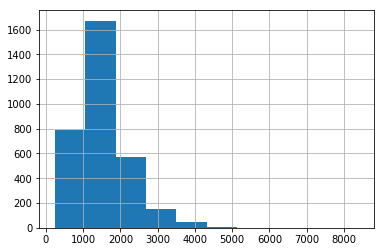

In [101]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
t1 = pd.read_table("temp/asyn_hemo.txt", sep=" ", names=("ID", "EVENT_ID", "ASYN","HEMO", "DATE"))
t1.ASYN.hist()

In [104]:
t1.dtypes

ID            int64
EVENT_ID     object
ASYN        float64
HEMO         object
dtype: object

In [143]:
def cut_hemo200(x):
    if x == "above":
        return 1
    elif x == "below":
        return 0
    elif x == ">20":
        return 99
    else:
        try:
            float(x)
            return 1
        except ValueError:
            return 999
t1['HEMO200'] = t1['HEMO'].apply(cut_hemo200)
if len(t1[t1['HEMO200']>998]) == 0:
    print("OK")

OK


In [160]:
t1['ASYN_num'] = pd.to_numeric(t1['ASYN'], errors="coerce")
t1['HEMO_num'] = pd.to_numeric(t1['HEMO'], errors="coerce")
t1[t1['HEMO_num']==NaN]

NameError: name 'NaN' is not defined